In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_imgs = np.zeros((16,10,64,64)) # 导入16组图片，每组10个数据，共计 160 张 训练样本，有点少，但收集起来太麻烦将就着用
for i in range(16):
    img = cv2.imread("train_data/train_data%d.jpg"%(i),0)
    img = cv2.GaussianBlur(img,(3,3),15) #高斯滤波稍微去点噪声
    img =  cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 25, 10)#自适应阈值二值化
    for j in range(10):
        newimg = img[:,(img.shape[1]//10)*j:(img.shape[1]//10)*(j+1)].copy() #将所有图片提取出来存储在 16 * 10 * 64 * 64 的4维数组里 
        train_imgs[i,j] = cv2.resize(newimg,(64,64))

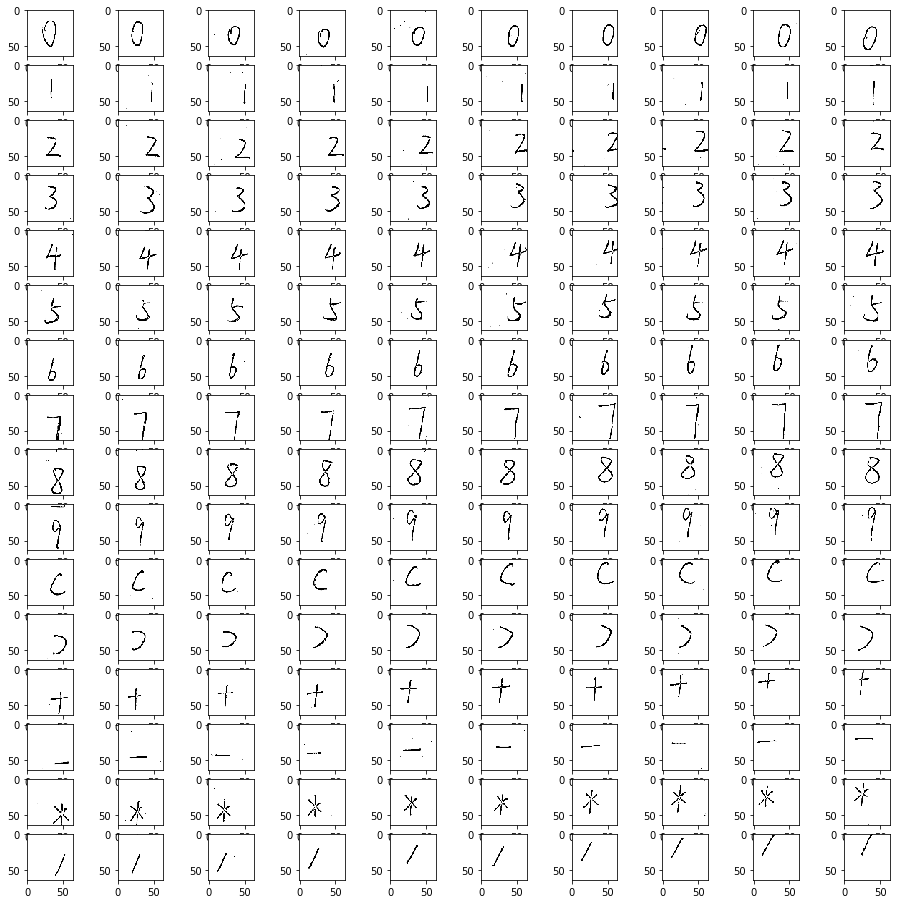

In [3]:
flag = 1  #用matplotlib将数据可视化
plt.figure(figsize=(16,16))
for i in range(16):
    for j in range(10):
        plt.subplot(16,10,flag)
        flag+=1
        plt.imshow(train_imgs[i,j],cmap=plt.cm.gray)

In [4]:
from sklearn import preprocessing #调用sklearn的数据预处理模块
def go_grad_dir_hist(src):  #定义一个求一形状为 (n * size * size) 的一组梯度方向直方图， 输出格式为 (n * 9) 
    grad = np.zeros_like(src)
    grad_dir = np.zeros_like(grad)
    grad_dir_hist = np.zeros((src.shape[0],9))
    filter_x = np.array([[-1,0,1],[-1,0,1],[-1,0,1]]) #x方向差分滤波器
    filter_y = np.array([[-1,-1,-1],[0,0,0],[1,1,1]]) #y方向差分滤波器
    for i in range(src.shape[0]):
        img = src[i].copy()
        gradx = cv2.filter2D(img, -1, filter_x) 
        grady = cv2.filter2D(img, -1, filter_y)
        gradx[gradx==0] = 1e-5 #防止分母为0
        grad_dir[i] = np.arctan(grady/gradx) * 180 / np.pi + 90 #计算梯度方向
        grad[i] = np.sqrt(gradx ** 2 + grady ** 2)   #计算梯度幅值
        for b in range(9):
            brange = b * 20 + 20
            gvalue = grad[i][np.logical_and(grad_dir[i] >= brange-20 ,grad_dir[i] < brange)]
            #提取在每个bin里的梯度值
            gdir = grad_dir[i][np.logical_and(grad_dir[i] >= brange-20 ,grad_dir[i] < brange)]
            #提取在每个bin里梯度方向
            grad_dir_hist[i,b] += (gvalue * (gdir - (brange - 20)) / 20).sum()
            #线性分割梯度值
            if b<=7:
                grad_dir_hist[i,b+1] += (gvalue * (brange - gdir) / 20).sum()
            else:
                grad_dir_hist[i,0] += (gvalue * (brange - gdir) / 20).sum()
                #大于160方向的一部分梯度值归于0方向上
    grad_dir_hist = preprocessing.normalize(grad_dir_hist,norm='l2') #用L2范数对数据正则化，归一化，以便可视化以及机器学习
    grad_dir_hist = np.array(grad_dir_hist, dtype=np.float32) # opencv 的 ml 模块强制 numpy 的 dtype 为 float32
    return grad_dir_hist

In [5]:
gd_hist = np.zeros((10,16,9)) #计算梯度方向直方图
for i in range(10):
    gd_hist[i] = go_grad_dir_hist(train_imgs[:,i,:,:])

In [6]:
gd_hist_mean = gd_hist.mean(axis=0) #将每组梯度方向直方图去均值

In [7]:
def draw_hist(gd_hist): #定义绘制梯度方向直方图函数
    plt.figure(figsize=(12,12))
    x = range(0, 180, 20)
    flag = 1
    for i in range(gd_hist.shape[0]):
        plt.subplot(4, 4, flag)
        flag+=1
        plt.xticks(x)
        plt.bar(x, gd_hist[i],width=15);

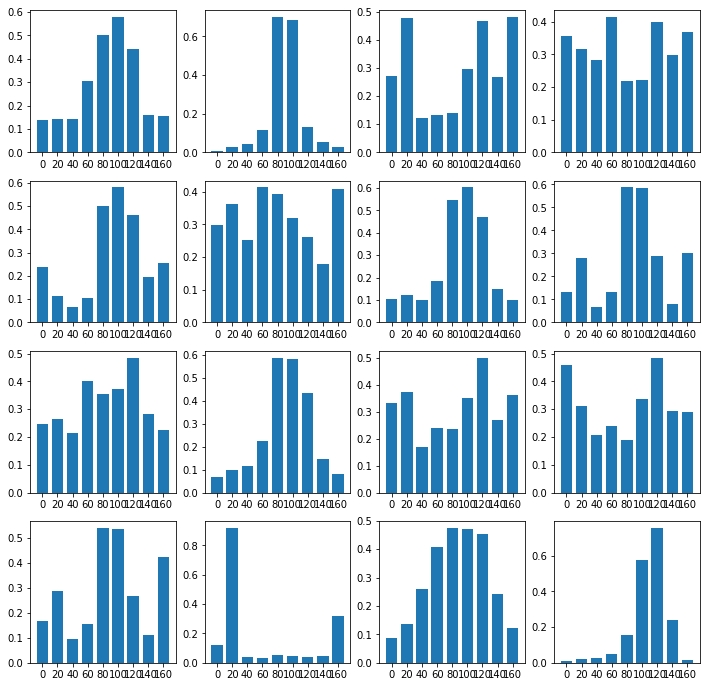

In [8]:
draw_hist(gd_hist_mean) #将均值化的梯度方向脂肪提显示出来

In [9]:
dictionrary = {0:'0' ,1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9' ,10:'(', 11:')', 12:'+', 13:'-', 14:'*', 15:'/'}
#这个字典用来对应索引和标签
def classifier(src, grad_dir_hist):#利用测试图片与均值化的16个直方图比较欧式距离，取最小欧式距离的为预测点
    pred = []
    for i in range(src.shape[0]):
        calc = np.array((((src[i]-grad_dir_hist)**2).sum(axis = 1)))        
        calc_index, = np.where(calc == calc.min(axis=0))
        pred.append(calc_index[0])
    return pred

In [10]:
for i in range(16): #这里来看看将训练数据用自定义预测是什么情况
    pred = classifier(go_grad_dir_hist(train_imgs[i,:,:,:]), gd_hist_mean)
    for j in range(10):
        print(dictionrary[int(pred[j])],end="")
    print()

0000000000
1111111111
2222222222
)533333833
4444444444
5555555555
0666669960
7777777777
0888888888
7999996999
()(((((32(
))2))))3))
+++++7++++
----------
**********
//////////


In [11]:
#可以看出，上面的这个分类器在训练集上收敛效果效果一般，考虑可以作为辅助的一个弱分类器

#接下来我打算再训练一个sklearn的决策树

In [12]:
test = 3 #测试数据为3个
gd_hist.shape = (160,9) #以下代码作用为，适应决策树的训练数据
machine_train_data = gd_hist[:16*(10-test),:].copy()
labels = np.arange(16)
machine_labels = labels.copy()
for i in range(9-test):
    machine_labels = np.concatenate((machine_labels, labels))
machine_train_data = np.array(machine_train_data, dtype=np.float32)
machine_labels.shape, machine_train_data.shape

((112,), (112, 9))

In [13]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier(max_depth=10,min_samples_leaf=2)
dtc.fit(machine_train_data, machine_labels)
dtc.score(machine_train_data, machine_labels)

0.9464285714285714

In [14]:
from sklearn.externals import joblib
#保存模型，因为这个决策树每次即使使用相同的训练数据结果都可能不一样，所以读者若是想自己跑我的代码还请务必用我预训练好的决策树
#joblib.dump(dtc, "train_model.m")

In [15]:
dtc = joblib.load("train_model.m")

In [16]:
machine_train_data.shape

(112, 9)

In [17]:
for i in range(dtc.predict(machine_train_data).shape[0]): #这里来看看决策树的预测结果，看起来好像还行
    print(dictionrary[int(dtc.predict(machine_train_data)[i])],end="")
    if i%16==15 :
        print()

0123456789()+-*/
0123436789()+-*/
0123456789()+-*/
0123456789()+-*/
0123456789()+-8/
0123456689()7-*/
01234567392)+-*/


In [18]:
#从这里就开始载入我的测试样本了，图示的为5组算式，我的demo就是为了精确识别并计算这5个算式。
#识别步骤：1.霍夫变换识别算式坐边的圆，以便提取每个算式的y坐标
        #  2.利用算法将每个字符框起来
        #  3.利用多个分类器以及自己的手动校正准确无误识别每个字符

((1, 8, 3), (1796, 2796))

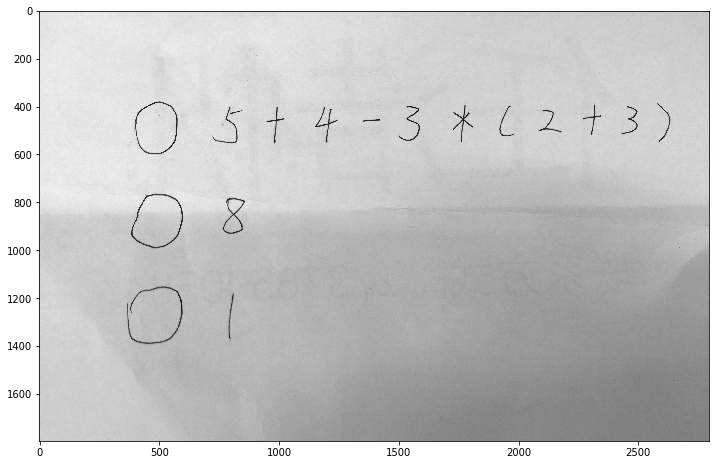

In [33]:
plt.figure(figsize=(12,12)) 
test3 = cv2.imread('test4.jpg',0)
test3 = cv2.resize(test3,(test3.shape[1]//2,test3.shape[0]//2))
plt.imshow(test3,cmap=plt.cm.gray)
circles = cv2.HoughCircles(test3,cv2.HOUGH_GRADIENT,1,30,param1=100,param2=34,minRadius=60,maxRadius=250) #霍夫变换识别大圆
circles.shape,test3.shape

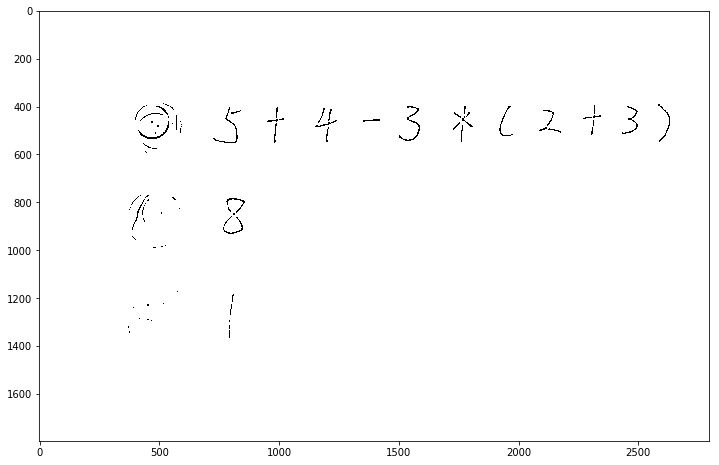

In [34]:
plt.figure(figsize=(12,12))
for i in circles[0]:
    cv2.circle(test3,(i[0],i[1]),i[2],128,10)
    cv2.circle(test3,(i[0],i[1]),2,128,5)
    test3 = cv2.GaussianBlur(test3,(5,5),10)
test3 =  cv2.adaptiveThreshold(test3, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 25, 10) #自适应阈值二值化
plt.imshow(test3,cmap=plt.cm.gray)

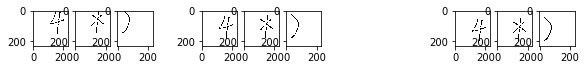

In [35]:
#这个代码块目的是利用算法将每个字符框取出来
rect = int(circles[0][4][2])#每个字符框选区一个随机圆的半径的两倍
plt.figure(figsize=(15,15))
mask = np.zeros((rect*2,rect*2))#字符的模板
test_imgs = []#所有字符最终保存的list
flag = 1
for i in range(int(circles[0].shape[0])):#循环 5 次
    delta = int(rect*9) #初始 x 坐标
    group = []
    flag+=1
    while True:
        mask = test3[int(circles[0,i,1])-rect:int(circles[0,i,1])+rect, delta-rect:delta+rect].copy()
        # 思路是先初始 x 坐标，然后每次递增一个delta值，如果检测到这个框左右两列都没有像素，也就是这个框没有把字符给截断，
        # 那么就认为这个框里的是一个字符。 如果检测到框里的像素都是白色，那就 break。迭代 5 次。
        if (mask==255).all():
            break
        if 2*rect-(mask[:,0]== 255).sum()<=0 and 2*rect-(mask[:,-1]== 255).sum()<=0:
            group.append(mask)
            plt.subplot(5, 20, flag)
            flag += 1
            plt.imshow(mask,cmap=plt.cm.gray)
        delta += int(rect)
    group = np.array(group)
    test_imgs.append(group)

In [37]:
#这是一个只针对我这一张图片的分类器。。。。。
#思路：  1.霍夫圆变换先找出 8 和 *（我也不知道为什么可以检测出‘*’，结果只有它形状为（0，0，0），就干脆挑出来得了）
        #2.再用一次霍夫圆变换，找出 3   0 9   3  ( 5 )    6  ，这些都差不多有那么一个或半个圆吧。剩下1 + 2 + + 4 + 2 + + 4 2 - 7 + / 1 + 1
        #3.利用霍夫线变换再次从以上两组数据中筛选，具体再下一个代码格里有写出
        #4.对 4 组图片分别适应我的两个弱分类器（自己写的一个，和一个决策树）
        #5.对这 2 个分类器预测的数据，手动进行校正， 类似的差不多就是把 ) 校正成 1 等等。。。。（花了一晚上 :( ）
plt.figure(figsize=(15,15))
flag = 0
result = []
for i in range(len(test_imgs)):
    group = []
    for j in range(test_imgs[i].shape[0]):
        circles1 = cv2.HoughCircles(test_imgs[i][j],cv2.HOUGH_GRADIENT,2,20,param1=10,param2=36,minRadius=15,maxRadius=30)       
        if not str(type(circles1))=="<class 'NoneType'>": 
#            print(circles1[0])
 #           print()            
            if circles1[0].shape[0] == 2:
                group.append('8')
                continue
            elif circles1[0][0][2] <=15:
                group.append('*')
                continue
            else:
                lines = cv2.HoughLines(255-test_imgs[i][j],2,np.pi/180,112)
                char = dictionrary[int(dtc.predict(go_grad_dir_hist((test_imgs[i][j].astype('float32')).reshape(1,130,130)).reshape(1,9)))]
                if not str(type(lines))=="<class 'NoneType'>":
  #                  print(lines.shape[0],(i,j))
                    if char == '2':
                        char = ')'
                    group.append(char)
                    continue
                else:
                    if char ==')':
                        char = '3'
                    elif char == '2':
                        char = '5'
                    elif char =='9':
                        char = '0'
                    group.append(char)
                    continue
        else:
            char1 = dictionrary[int(dtc.predict(go_grad_dir_hist((test_imgs[i][j].astype('float32')).reshape(1,130,130)).reshape(1,9)))]
            char2 = dictionrary[int(classifier(go_grad_dir_hist((test_imgs[i][j].astype('float32')).reshape(1,130,130)).reshape(1,9), gd_hist_mean)[0])]
            print(char1,end='')
            circles2 = cv2.HoughCircles(test_imgs[i][j],cv2.HOUGH_GRADIENT,2,20,param1=10,param2=41,minRadius=1,maxRadius=60)       
            if not str(type(circles2))=="<class 'NoneType'>": 
                if char1 == '6':
                    char1 = '4'
                group.append(char1)
                continue
            else:
                if char1 == '4' and char2 == '6':
                    group.append('+')
                    continue
                elif char1 == '6':
                    group.append('+')
                    continue               
                else:
                    if char1 == '-' and char2 == '6':
                        group.append('7') 
                    else:                        
                        group.append(char2)          
                        continue           
    result.append(group)

ValueError: cannot reshape array of size 53824 into shape (1,130,130)

<Figure size 1080x1080 with 0 Axes>

         3   0 9   3  ( 5 )    6                             1 + 2 + + 4 + 2 + + 4 2 - 7 + / 1 + 1                                                            
分类器1  )   9 9   3  ( 2 2    6               分类器1       1 4 2 6 6 4 6 2 6 6 6 2 2 - 6 - 1 6 -
识别错误 3   0          5 )                    分类器2       1 6 ( 6 7 6 6 ( 6 6 6 ( - 6 6 / 1 7 1
正确的         9   3  (        6
选出的         9      (   )    6               选出的基于1       2     4   2     4 2
剩余的   3   0     3    5                      基于1&2         +   + +   +   + +       7 +     +
第二预测 )   9     3    2                      基于2         1                       -     / 1   1


In [23]:
result #识别最终结果

[['1', '+', '2', '+', '3', '+', '4'],
 ['0', '+', '2', '+', '9'],
 ['3', '+', '4', '*', '2', '-', '(', '7', '+', '5', ')', '/', '8'],
 ['1', '+', '1'],
 ['6']]

In [24]:
#计算函数，思路是先找括号，把括号里的结果算出来，然后再找 * 和 / ，最后计算 + 和 -
def calculate2(lt0):
    lt = lt0.copy()
    lt = np.array(lt,dtype='<U9')
    while '/' in lt:
        index = int(np.where(lt == '/')[0][0])
        lt[index+1] = str(1/float(lt[index+1]))
        lt[index] = '*'
    while '*' in lt:
        index = int(np.where(lt == '*')[0][0])
        lt[index] = str(float(lt[index-1])*float(lt[index+1]))
        lt = np.delete(lt,index-1,axis=0)
        lt = np.delete(lt,index,axis=0)
    while '+' in lt:
        index = int(np.where(lt == '+')[0][0])
        lt[index] = str(float(lt[index-1])+float(lt[index+1]))
        lt = np.delete(lt,index-1,axis=0)
        lt = np.delete(lt,index,axis=0)
    while '-' in lt:
        index = int(np.where(lt == '-')[0][0])
        lt[index] = str(float(lt[index-1])-float(lt[index+1]))
        lt = np.delete(lt,index-1,axis=0)
        lt = np.delete(lt,index,axis=0) 
    return lt[0]

def calculate(lt0):
    lt = lt0.copy()
    lt = np.array(lt,dtype='<U9')
    value=0
    while '(' in lt:
        index = int(np.where( lt== '(')[0][-1])
        index2 = int(np.where(lt == ')')[0][0])
        lt_cut = lt[index+1:index2]
        lt = np.delete(lt,range(index, index2+1), axis=0)
        value = calculate2(lt_cut)
        lt = np.insert(lt,index ,value)
    return calculate2(lt)  

In [25]:
for i in range(len(result)): #终于出来了！！
    result[i].append("=")
    result[i].append(calculate(result[i]))
result

[['1', '+', '2', '+', '3', '+', '4', '=', '10.0'],
 ['0', '+', '2', '+', '9', '=', '11.0'],
 ['3', '+', '4', '*', '2', '-', '(', '7', '+', '5', ')', '/', '8', '=', '9.5'],
 ['1', '+', '1', '=', '2.0'],
 ['6', '=', '6']]